# PyDay Chile 2020

Puedes descargar el dataset utilizado haciendo click [aquí](https://drive.google.com/u/0/uc?export=download&confirm=9sqH&id=1Ugbsw5XbNRbglomSQO1qkAgMFB_3BzmB)

## 1. Análisis Exploratorio de los datos (EDA)

### <font color=Blue>__¿Qué es el Análisis Exploratorio de Datos?__</font>

Analisis Exploratorio de los Datos o EDA (en ingles, 'Exploratory Data Analysis') es un paso previo e imprescindible a
la hora de comprender los datos con los que se va a trabajar y altamente recomendable para una
correcta metodología de investigación.

El objetivo de este análisis es explorar, describir, resumir y visualizar la naturaleza de los datos recogidos en
las variables del proyecto o investigación de interés, mediante la aplicación de técnicas simples de resumen de datos y
métodos gráficos sin asumir asunciones para su interpretación.
Luego de la Adquisicion de los datos, el EDA es el tercer paso en todo proyecto de Analisis de Datos.

Las principales herramientas que usaremos para realizar este análisis seran: `Pandas` y `SciKit Learn` para manipular los datos
asi como `Matplotlib` y `Seaborn` para su visualización.

In [2]:
# Importamos las librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('tmp/data/DS_Proyecto_01_Datos_Properati.csv', parse_dates=['end_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146660 entries, 0 to 146659
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   start_date       146660 non-null  object 
 1   end_date         146660 non-null  object 
 2   created_on       146660 non-null  object 
 3   lat              136735 non-null  float64
 4   lon              136701 non-null  float64
 5   l1               146660 non-null  object 
 6   l2               146660 non-null  object 
 7   l3               146660 non-null  object 
 8   rooms            146660 non-null  float64
 9   bedrooms         146660 non-null  float64
 10  bathrooms        140703 non-null  float64
 11  surface_total    126133 non-null  float64
 12  surface_covered  125046 non-null  float64
 13  price            146660 non-null  float64
 14  currency         146660 non-null  object 
 15  title            146660 non-null  object 
 16  description      146660 non-null  obje

### <font color=Blue>__Arreglando los datatypes__</font>

In [4]:
df.end_date.sample(5)

72005    2019-06-09
8777     2019-11-29
59687    9999-12-31
59933    9999-12-31
37427    2019-03-09
Name: end_date, dtype: object

In [5]:
df.bedrooms.sample(5)

133436    1.0
5052      3.0
29084     2.0
84267     2.0
73429     3.0
Name: bedrooms, dtype: float64

In [6]:
# dates to datetime
dates = ['start_date', 'end_date', 'created_on']
for i in dates:
    df[i] = pd.to_datetime(df[i], yearfirst=True, errors='coerce') #algunas end_date no terminaron

# to integer    
for amb in ['rooms', 'bedrooms', 'bathrooms']:
    df[amb] = df[amb].astype(int, errors='ignore')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146660 entries, 0 to 146659
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   start_date       146660 non-null  datetime64[ns]
 1   end_date         121559 non-null  datetime64[ns]
 2   created_on       146660 non-null  datetime64[ns]
 3   lat              136735 non-null  float64       
 4   lon              136701 non-null  float64       
 5   l1               146660 non-null  object        
 6   l2               146660 non-null  object        
 7   l3               146660 non-null  object        
 8   rooms            146660 non-null  int64         
 9   bedrooms         146660 non-null  int64         
 10  bathrooms        140703 non-null  float64       
 11  surface_total    126133 non-null  float64       
 12  surface_covered  125046 non-null  float64       
 13  price            146660 non-null  float64       
 14  currency         146

In [7]:
# Estadistica descriptiva de variables cuantitativas
df.describe().round(2)

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,136735.00,136701.00,146660.00,146660.00,140703.00,126133.00,125046.00,146660.00
mean,-34.60,-58.47,3.08,1.98,1.60,216.87,112.82,241221.08
std,0.47,0.49,1.42,1.15,0.89,2037.61,916.86,318519.46
min,-35.32,-180.00,1.00,0.00,1.00,10.00,1.00,5500.00
25%,-34.63,-58.50,2.00,1.00,1.00,52.00,47.00,111000.00
50%,-34.60,-58.44,3.00,2.00,1.00,78.00,68.00,166000.00
75%,-34.57,-58.41,4.00,3.00,2.00,140.00,108.00,265000.00
max,85.05,-57.81,35.00,15.00,14.00,193549.00,126062.00,32434232.00


In [8]:
# Casos nulos por feature (%)
(df.isna().sum() / df.shape[0] * 100).sort_values(ascending=False).round(1)

end_date           17.1
surface_covered    14.7
surface_total      14.0
lon                 6.8
lat                 6.8
bathrooms           4.1
operation_type      0.0
l3                  0.0
created_on          0.0
l1                  0.0
l2                  0.0
bedrooms            0.0
rooms               0.0
property_type       0.0
price               0.0
currency            0.0
title               0.0
description         0.0
start_date          0.0
dtype: float64

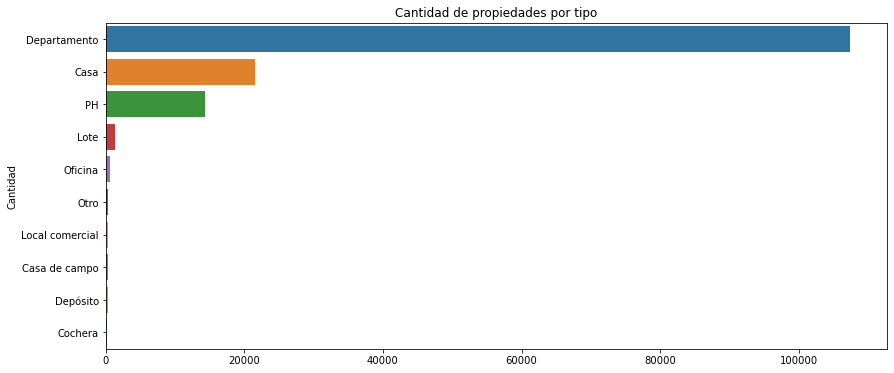

In [9]:
plt.figure(figsize = (14,6))
chart = sns.countplot(data = df,
                      y = "property_type",
                      order= df.property_type.value_counts().index)
chart.set(xlabel = None, ylabel = 'Cantidad')
plt.title('Cantidad de propiedades por tipo')
plt.show()

**Conclusión** 

Departamentos, PH y Casa son los únicos tipos de propiedad que tienen volumen de datos suficientes como para trabajar

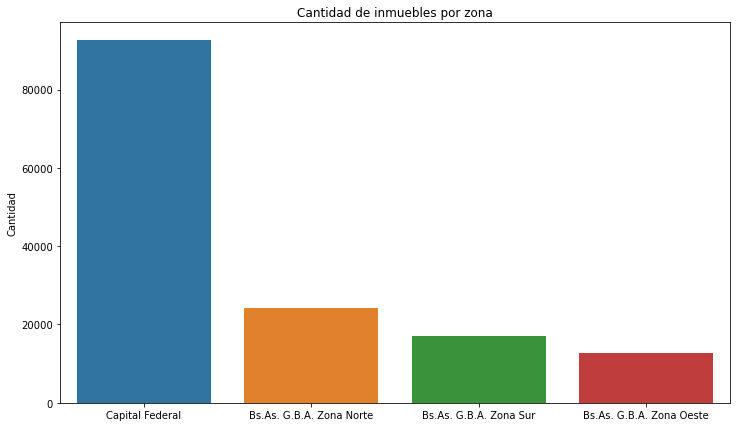

In [10]:
# Publicaciones por zona
plt.figure(figsize = (12,7))
l2 = sns.countplot(data=df,
                   x="l2",
                   order=df.l2.value_counts().index)
l2.set(xlabel = None, ylabel = 'Cantidad')
plt.title('Cantidad de inmuebles por zona')
plt.show()

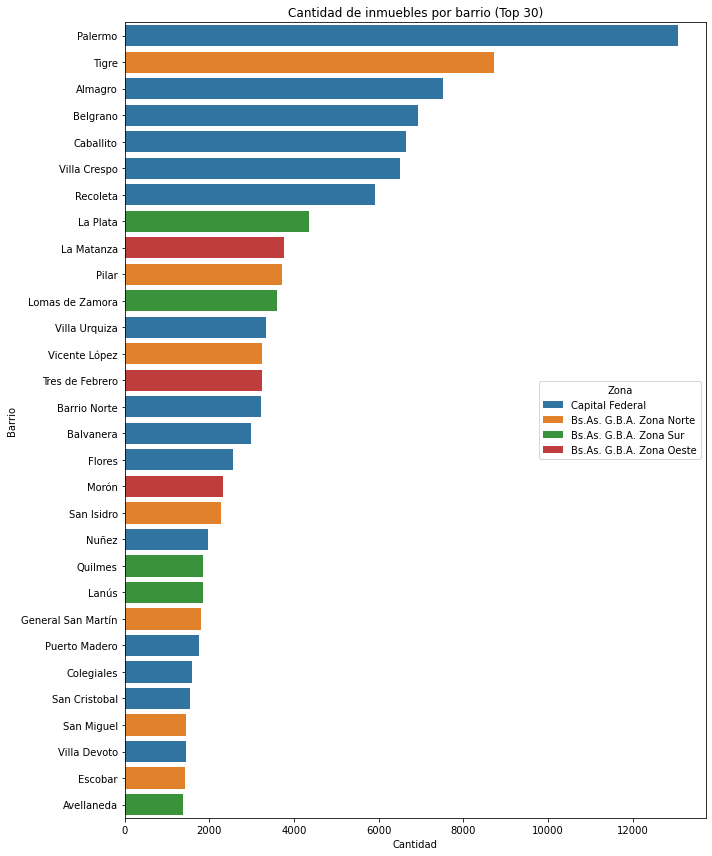

In [11]:
# Top 30 barrios mas publicados
plt.figure(figsize = (10,12))
l3 = sns.countplot(data=df,y="l3",
                   order = df['l3'].value_counts().index[:30], 
                   hue='l2',
                   hue_order= df.l2.value_counts().index, # Por que quiero el mismo color que arriba
                   dodge=False
                  )
l3.set_xlabel('Cantidad')
l3.set_ylabel('Barrio')
l3.legend(title='Zona', loc='center right')
plt.title('Cantidad de inmuebles por barrio (Top 30)')
plt.tight_layout()
plt.show()

In [12]:
# Cantidad de barrios unicos publicados por zona
df.groupby('l2')['l3'].nunique()

l2
Bs.As. G.B.A. Zona Norte    10
Bs.As. G.B.A. Zona Oeste     9
Bs.As. G.B.A. Zona Sur      13
Capital Federal             57
Name: l3, dtype: int64

**Conclusión**

Capital Federal es la zona que tiene mayor cantidad de propiedades.<br>
De los 5 barrios mas publicados, 4 corresponden a la Capital.<br>
En Promedio, la Capital Federal reporta 5 veces mas barrios distintos que las otras zonas.<br>

In [13]:
def filter_outliers(col, percentiles = [.025, .975]):
    filter_col = col[(col > col.quantile(percentiles[0])) & 
                     (col < col.quantile(percentiles[1]))
                        ]
    return filter_col.index

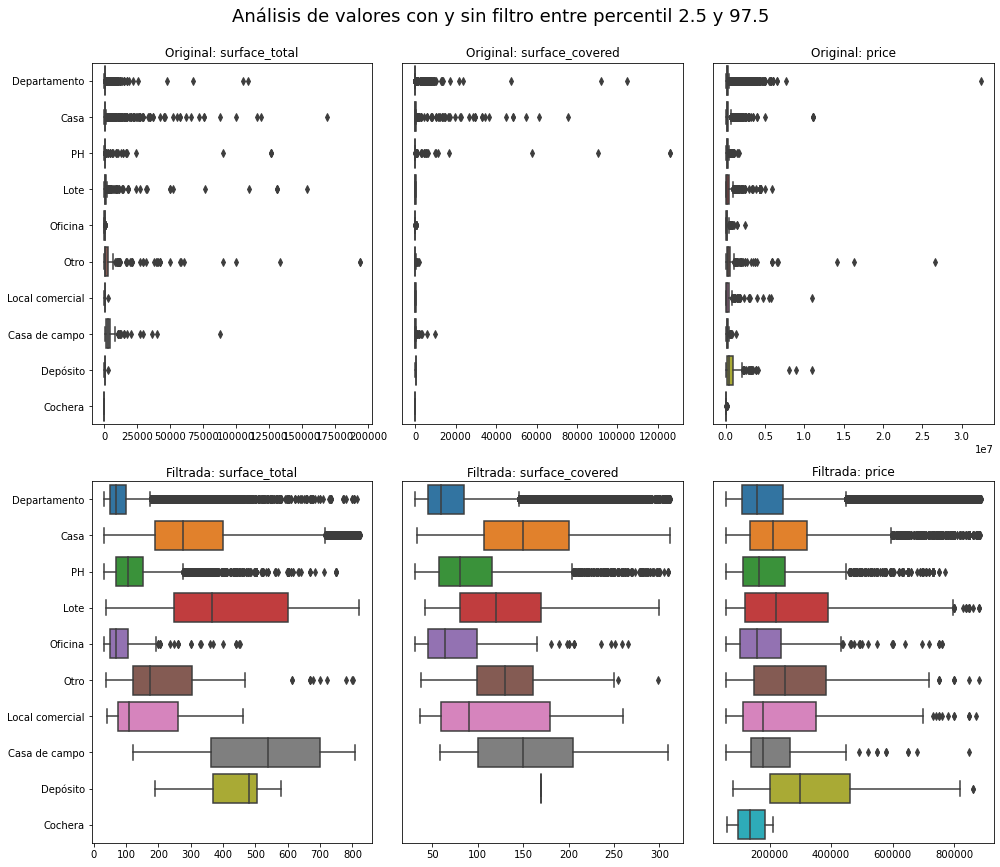

In [14]:
columns = ['surface_total', 'surface_covered','price']
order = df.property_type.value_counts().index
fig, axs = plt.subplots(2,3,figsize=(14,12))

for n,col in enumerate(columns):
    filter_df = df.iloc[filter_outliers(df[col])]
    
    axs[0,n].set_title(f'Original: {col}')
    sns.boxplot(data = df,
                y='property_type',
                x=col,
                order=order,
                ax=axs[0,n])
    if n > 0:
        axs[0,n].set_yticks([])
    axs[0,n].set_xlabel(None)
    axs[0,n].set_ylabel(None)
    
    axs[1,n].set_title(f'Filtrada: {col}')
    sns.boxplot(data = filter_df,
                y='property_type',
                x=col,
                order=order,
                ax=axs[1,n])
    if n > 0:
        axs[1,n].set_yticks([])
    axs[1,n].set_ylabel(None)
    axs[1,n].set_xlabel(None)
    
    
fig.suptitle('Análisis de valores con y sin filtro entre percentil 2.5 y 97.5', y=1, size=18)
plt.tight_layout()
plt.show()

**Conclusión**

Estos gráficos filtados nos permiten permiten identificar según el tipo de propiedad la dispersión de los features.
Sin filtrar, las propiedades de `surface_covered`, `surface_total` y `price` tenían valores muy altos y bajos
según el `sns.boxplot()` y `pd.describe()`.<br>
Para ellos, filtramos entre percentil 2.5 y 97.5 a modo de quitar valores atípicos de: <br>
`price` (vimos precios minimos de USD 6.000 que son incongruentes con los valores de CABA), <br>
`surface_covered` (vimos propiedades que tienen 1mt2 de superficie cubierta que es incongruente con CABA) y <br>
`surface_total`(vimos valores de superficie total de 13mts, incogruente con Casas, PH y Departamentos en CABA).

### <font color=Blue>__Correlación__</font>

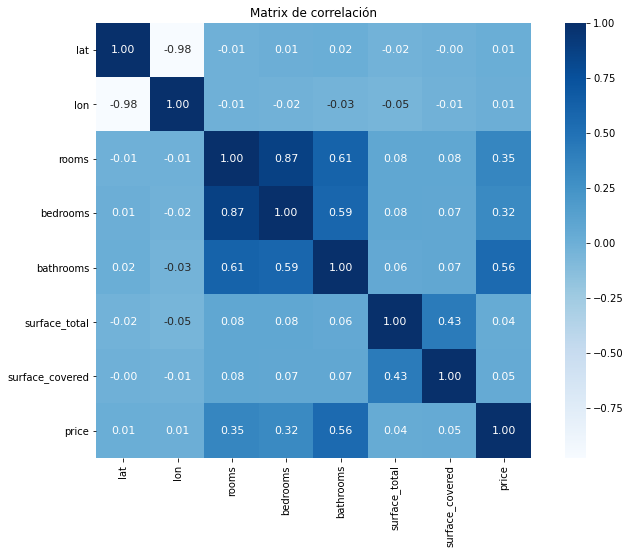

In [15]:
corr = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 11}, cmap= 'Blues')
plt.title('Matrix de correlación')
plt.show()

### <font color=Blue>__Filtrado del Dataset__</font>

- Seleccionamos aquellas propiedades en Capital Federal y cuyo tipo de propiedad es Departamento, PH o Casa.
- Seleccionamos aquellas propiedades cuya superficie total es menor a 1000 m2 y mayor a 15 m2.
- Descartamos aquellas propiedades cuya sup. cubierta sea mayor a la sup. total.
- Seleccionamos aquellas propiedades cuya precio es menor 4000000 dólares.
- Seleccionamos solamente las columnas `rooms`, `bedrooms`, `bathrooms`, `surface_total`, `surface_covered` y `price`.
- Descartamos aquellas instacias con valores faltantes (ver [missing value imputation](https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779) para alternativas)

In [16]:
property_filter = ['Departamento', 'PH', 'Casa']
df = df[(df.property_type.isin(property_filter)) & (df.l2 == "Capital Federal")]
df = df[(df.surface_total >= 15) & (df.surface_total <= 1000)]
df = df[(df.price <= 4000000)]
df = df[df.surface_total >= df.surface_covered]
columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered','price']
df = df[columns]
df.dropna(inplace=True)
df.shape

(80276, 6)

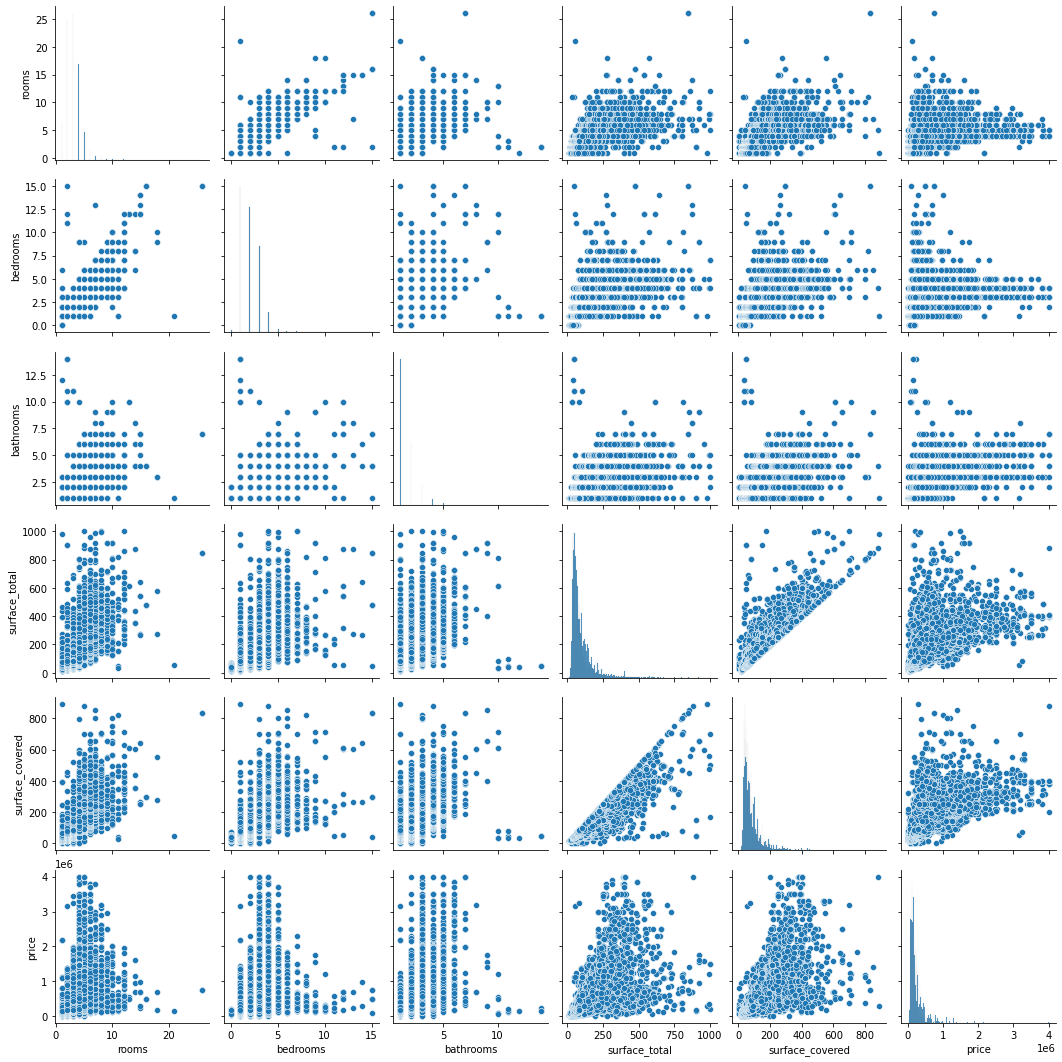

In [17]:
sns.pairplot(df)
plt.show()

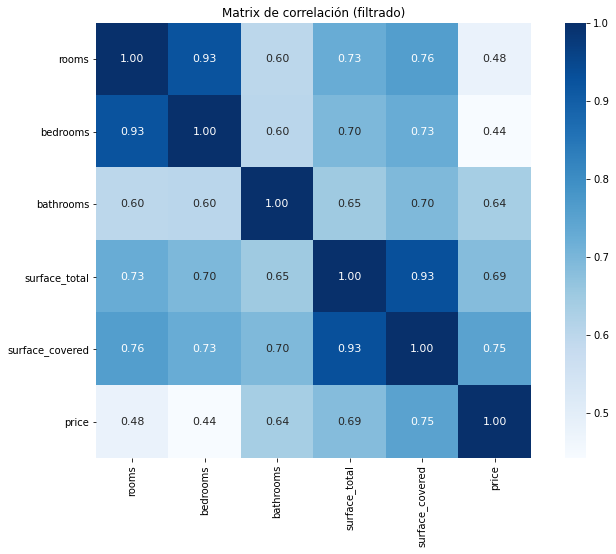

In [18]:
# Correlación luego de filtrar
corr = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 11}, cmap= 'Blues')
plt.title('Matrix de correlación (filtrado)')
plt.show()

### 2. Entrenando un modelo de Machine Learning con Python
![Machine Learning](https://raw.githubusercontent.com/joaquinmenendez/PyDay_Chile_Acamica/main/tmp/images/ML.png)

### <font color=Blue>__Features y Target (X & y)__</font>

In [38]:
X = df[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered' ]]
y = df.price

### <font color=Blue>__Test & Train set__</font>

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler = StandardScaler()

In [21]:
# Escalamos nuestros datos
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### <font color=Blue>__KNN (K-Nearest Neighbors)__</font>

**IDEA**<br>
Dada una nueva instancia de la cual no conocemos la etiqueta objetivo, vamos a asumir que su etiqueta será igual a la de
 las instancias “vecinas” en el training set.

O dicho de otra forma...
> Dime con quién andas y te diré quien eres.

![knn](https://miro.medium.com/max/1080/0*49s1xDlDKDsn55xa.gif)<br>
*Ejemplo gráfico del algoritmo de KNN*

### <font color=Blue>Hyperparameter tuning - Buscamos el mejor valor de vecinos</font>

In [22]:
list_mae_train = []
list_mae_test = []
list_rmse_train = []
list_rmse_test = []

k_vecinos = range(1, 30)

for k in k_vecinos:

    clf = KNeighborsRegressor(n_neighbors= k, weights= 'distance')

    clf.fit(X_train, y_train)

    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = clf.predict(X_train)
    train_mae =  mean_absolute_error(y_train_pred, y_train)
    train_rmse =  np.sqrt(mean_squared_error(y_train_pred, y_train))

    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = clf.predict(X_test)
    test_mae = mean_absolute_error(y_test_pred,y_test)
    test_rmse = np.sqrt(mean_squared_error(y_test_pred, y_test))

    list_mae_train.append(train_mae)
    list_mae_test.append(test_mae)
    list_rmse_train.append(train_rmse)
    list_rmse_test.append(test_rmse)

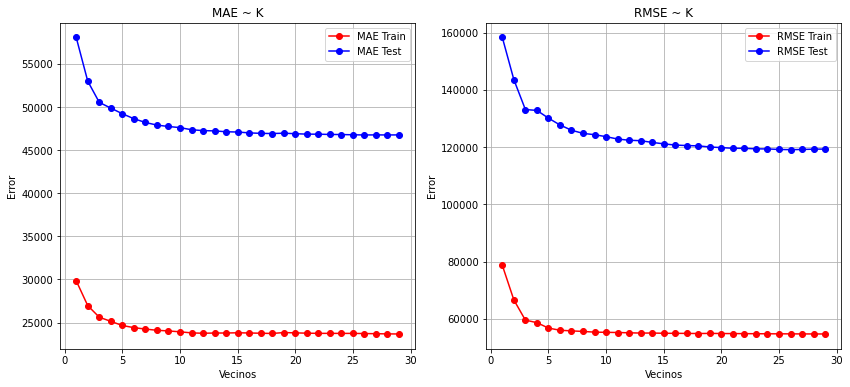

In [23]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
# MAE
axs[0].plot(k_vecinos, list_mae_train,'o-', c='r', label='MAE Train')
axs[0].plot(k_vecinos, list_mae_test,'o-',c='b', label='MAE Test')
axs[0].legend()
axs[0].grid(k_vecinos)
axs[0].set_xlabel('Vecinos')
axs[0].set_ylabel('Error')
axs[0].set_title('MAE ~ K')
#RMSE
axs[1].plot(k_vecinos, list_rmse_train,'o-',c='r', label='RMSE Train')
axs[1].plot(k_vecinos, list_rmse_test,'o-',c='b', label='RMSE Test')
axs[1].legend()
axs[1].grid(k_vecinos)
axs[1].set_xlabel('Vecinos')
axs[1].set_ylabel('Error')
axs[1].set_title('RMSE ~ K')

plt.show()

### <font color=Blue>Definimos la configuración final del modelo</font>

In [24]:
knn_regressor = KNeighborsRegressor(n_neighbors=7, weights='distance')
knn_regressor.fit(X_train, y_train)

y_train_pred = knn_regressor.predict(X_train)
y_test_pred = knn_regressor.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print('Root Mean Squared Error en Train:',"%.0f" % rmse_train)
print('Root Mean Squared Error en Test:',"%.0f" % rmse_test)
print('Mean Absolute Error en Train:',"%.0f" % mae_train)
print('Mean Absolute Error en Test:',"%.0f" % mae_test)

Root Mean Squared Error en Train: 55771
Root Mean Squared Error en Test: 125892
Mean Absolute Error en Train: 24247
Mean Absolute Error en Test: 48203


### <font color=Blue>Graficamos la dispersión del error</font>

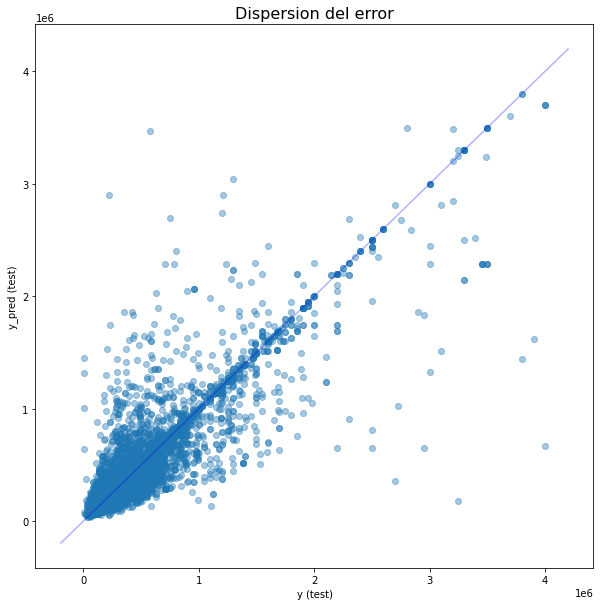

In [25]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(y_test,y_test_pred, alpha = 0.4)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    
ax.plot(lims, lims, 'k-', alpha=0.3, zorder=1, color='b')

plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
plt.title('Dispersion del error', size=16)
plt.show()

## 3. Puesta en Producción del modelo
Una vez que definimos el modelo, tuneamos sus hiper parámetros y estamos conformes con el
resultado de sus métricas entrenámos con todos los datos disponibles, guardamos este modelo fianl y lo insertamos en una clase.

### <font color=Blue>__Entrenamos con todos nuestros datos__</font>

In [39]:
scaler_final = StandardScaler()
X = scaler_final.fit_transform(X)
knn_regressor = KNeighborsRegressor(n_neighbors=7, weights='distance')
knn_regressor.fit(X, y)
model = {"modelo":knn_regressor,
         "scaler":scaler_final}

### <font color=Blue>__Guardamos el modelo y el StandardScaler__</font>

In [43]:
import pickle
with open('./tmp/model.pickle','wb') as file:
    pickle.dump(model, file)

### <font color=Blue>__Definimos una clase para devolver futuras predicciones__</font>

In [40]:
# Definimos una clase llamada Property
class Property:

    def __init__(self):
        # To make the instantiation more interactive we will use `input`
        self.rooms = int(input("Rooms: "))
        self.bedrooms = int(input("Bedrooms: "))
        self.bathrooms = int(input("Bathrooms: "))
        self.surface_total = int(input("Surface Total (m2): "))
        self.surface_covered = int(input("Surface Covered (m2): "))

    def __repr__(self):
        return (f'{self.__class__.__name__}('
                f'{self.rooms}, {self.bedrooms}, {self.bathrooms}, '
                f'{self.surface_total}, {self.surface_covered})')


    def predictValue(self, printable = False):
        """
        Returns an estimate price in dollars for the property
        :param printable: Bool - Default: False. Prints a message with the estimated value
        :return: float
        """
        # Create an array with the object attributes
        property_values = [att for att in self.__dict__.values()]
        property_values = np.array(property_values).reshape(1, -1)
        property_values = model["scaler"].transform(property_values)
        price_pred = model["modelo"].predict(property_values)[0] #It's only one value
        if printable:
            print(f'Esta propiedad tiene un valor estimado de: {price_pred:.0f}')
        else:
            return price_pred

### <font color=Blue>Propiedad de prueba</font>

Propiedad publicada en [Zonaprop](https://www.zonaprop.com.ar/propiedades/departamento-3-ambientes.-las-heras-al-2300-46602803.html)

**Características**
- 3 Ambientes
- 2 Dormitorios
- 2 Baños
- Total 82 m²
- Cubierta 82 m²

USD 249.000

In [41]:
# Inicializamos nuestra clase
nueva_prop = Property()
nueva_prop

Property(3, 2, 2, 82, 82)

In [42]:
# Estimamos el valor
nueva_prop.predictValue(printable=True)


Esta propiedad tiene un valor estimado de: 226000
